<a href="https://colab.research.google.com/github/moqri/deep_cell/blob/master/CNNC/rnaseq2image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
folder='adultPancreas'
expressions_url='https://cells.ucsc.edu/adultPancreas/exprMatrix.tsv.gz'

In [0]:
# Download the data 
!mkdir {folder}
!wget -O {folder}/exprMatrix.tsv.gz {expressions_url}

mkdir: cannot create directory ‘adultPancreas’: File exists
--2020-02-14 22:13:12--  https://cells.ucsc.edu/adultPancreas/exprMatrix.tsv.gz
Resolving cells.ucsc.edu (cells.ucsc.edu)... 128.114.119.132, 128.114.119.131
Connecting to cells.ucsc.edu (cells.ucsc.edu)|128.114.119.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22707068 (22M) [application/x-gzip]
Saving to: ‘adultPancreas/exprMatrix.tsv.gz’

adultPancreas/exprM 100%[===================>]  21.65M  10.5MB/s    in 2.1s    

2020-02-14 22:13:14 (10.5 MB/s) - ‘adultPancreas/exprMatrix.tsv.gz’ saved [22707068/22707068]



In [0]:
import numpy as np
import pandas as pd

In [0]:
expression_df = pd.read_table(folder+"/exprMatrix.tsv.gz",index_col=0).transpose()
expression_df.index.rename('cell_id',inplace=1)
expression_df.shape

(4026, 23450)

In [0]:
genes=[item[0] for item in expression_df.columns.str.split('|'[0])] # correct the names of the genes
expression_df.columns=genes
expression_df.head()

,AA06,AAA1,AAAS,AACS,AACSP1,AADAC,AADACL2,AADACL3,AADACL4,AADAT,AAGAB,AAK1,AAMP,AANAT,AARS,AARS2,AARSD1,AASDH,AASDHPPT,AASS,AATF,AATK,AATK-AS1,ABAT,ABCA1,ABCA10,ABCA11P,ABCA12,ABCA13,ABCA17P,ABCA2,ABCA3,ABCA4,ABCA5,ABCA6,ABCA7,ABCA8,ABCA9,ABCB1,ABCB10,...,ZRANB2-AS1,ZRANB2-AS2,ZRANB3,ZRSR2,ZSCAN1,ZSCAN10,ZSCAN12,ZSCAN12P1,ZSCAN16,ZSCAN18,ZSCAN2,ZSCAN20,ZSCAN21,ZSCAN22,ZSCAN23,ZSCAN29,ZSCAN30,ZSCAN4,ZSCAN5A,ZSCAN5B,ZSWIM1,ZSWIM2,ZSWIM3,ZSWIM4,ZSWIM5,ZSWIM6,ZSWIM7,ZUFSP,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,tAKR
cell_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
X1000010011.A01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,0,0,3,0,0,0,0,0,12,0,0,0,0,0,0,0,0,0,24,12,0,0,0,0,0,...,8,0,0,0,0,0,0,0,0,1,0,0,7,0,0,0,0,0,40,0,0,0,0,0,0,1,13,14,0,0,0,0,0,0,0,99,0,0,108,0
X1000010011.A02,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,148,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,41,0,0,0,0,0,...,0,0,0,0,0,0,0,11,0,50,0,0,0,0,0,0,0,0,0,0,36,0,0,0,0,0,0,0,0,0,0,0,17,0,0,30,0,0,0,0
X1000010011.A03,0,0,0,41,0,0,0,0,0,0,0,124,12,0,0,0,0,0,85,0,0,0,0,164,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,93,0,0,0,0,0,0,0,0,0,0,0,0,0,0
X1000010011.A04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,94,6,0,0,0,0,0,1,0,0,230,0,0,0,0,0,5,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,2,0,0,0,0,0,0,0,0,0,0,6,0,0,0
X1000010011.A05,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,0,0,0,0,0,95,0,0,0,0,0,0,0,0,0,5,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,57,0,0,0,0,0,115,0,454,0,0,0,26,0,0,0,0,0,0,0


In [0]:
#drop controls -starting with 'ERCC'
genes_no_ERCC=[x for x in genes if not x.startswith('ERCC')]
expression_df=expression_df[genes_no_ERCC]
expression_df.shape

(4026, 23350)

In [0]:
expression_df=expression_df.loc[:, (expression_df != expression_df.iloc[0]).any()]  # remove constant columns
expression_df.shape

(4026, 21712)

In [0]:
expression_df=expression_df[(expression_df.T != 0).any()] # remove rows of zeros
expression_df.shape

(3942, 21712)

In [0]:
# drop low count genes
gene_count=expression_df.astype(bool).sum(axis=0)
cells=expression_df.count()
expression_df=expression_df[gene_count[gene_count>cells/100].index]
expression_df.shape

(3942, 14995)

In [0]:
# get expression as percentage
expression_df=(100*expression_df.transpose() / expression_df.sum(1)).round(2).transpose()
expression_df

,AAA1,AAAS,AACS,AADAC,AADAT,AAGAB,AAK1,AAMP,AARS,AARS2,AARSD1,AASDH,AASDHPPT,AASS,AATF,AATK,ABAT,ABCA1,ABCA10,ABCA11P,ABCA17P,ABCA2,ABCA3,ABCA5,ABCA6,ABCA7,ABCA8,ABCA9,ABCB1,ABCB10,ABCB4,ABCB6,ABCB7,ABCB8,ABCB9,ABCC1,ABCC10,ABCC2,ABCC3,ABCC4,...,ZNRF3,ZP1,ZP3,ZPBP,ZPLD1,ZRANB1,ZRANB2,ZRANB2-AS1,ZRANB2-AS2,ZRANB3,ZRSR2,ZSCAN1,ZSCAN12,ZSCAN12P1,ZSCAN16,ZSCAN18,ZSCAN2,ZSCAN20,ZSCAN21,ZSCAN22,ZSCAN23,ZSCAN29,ZSCAN30,ZSCAN5A,ZSWIM1,ZSWIM4,ZSWIM5,ZSWIM6,ZSWIM7,ZUFSP,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3
cell_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
X1000010011.A01,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.01,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.03,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.00,0.0,0.0,0.00,0.00,0.01,0.00,0.0,0.0,0.0,0.00,0.0,0.04,0.00,0.0,0.04
X1000010011.A02,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.07,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.02,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.00,0.0,0.01,0.0,0.02,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.02,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.01,0.0,0.01,0.00,0.0,0.00
X1000010011.A03,0.0,0.00,0.01,0.0,0.0,0.0,0.04,0.00,0.00,0.0,0.00,0.0,0.03,0.0,0.00,0.0,0.05,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.00
X1000010011.A04,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.07,0.00,0.0,0.00,0.0,0.0,0.0,0.18,0.00,0.0,0.0,0.0,0.00,0.0,0.09,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.00
X1000010011.A05,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.01,0.0,0.00,0.0,0.00,0.0,0.03,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.01,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.02,0.0,0.0,0.00,0.04,0.00,0.15,0.0,0.0,0.0,0.01,0.0,0.00,0.00,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X1000103103.H5,0.0,0.02,0.00,0.0,0.0,0.0,0.00,0.03,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.02,0.0,0.0,0.0,0.04,0.00,0.0,0.0,0.0,0.01,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.03,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.00
X1000103103.H6,0.0,0.00,0.00,0.0,0.0,0.0,0.01,0.01,0.03,0.0,0.01,0.0,0.00,0.0,0.01,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.01,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.03,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.01,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.01,0.0,0.00
X1000103103.H7,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.02,0.07,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.02,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.02,0.0,0.00,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.01,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.01,0.00,0.00,0.0,0.0,0.0,0.02,0.0,0.00,0.00,0.0,0.00


In [0]:
# most expressed genes
gene_sum=expression_df.sum()
top_genes=gene_sum.sort_values().tail(10)
top_genes

CELA3A     1993.37
PNLIP      2630.45
CPB1       3153.61
CPA1       3325.39
REG1A      3719.98
INS        4986.29
TTR        6008.04
PRSS1      6741.03
MALAT1    10552.14
GCG       14161.43
dtype: float64

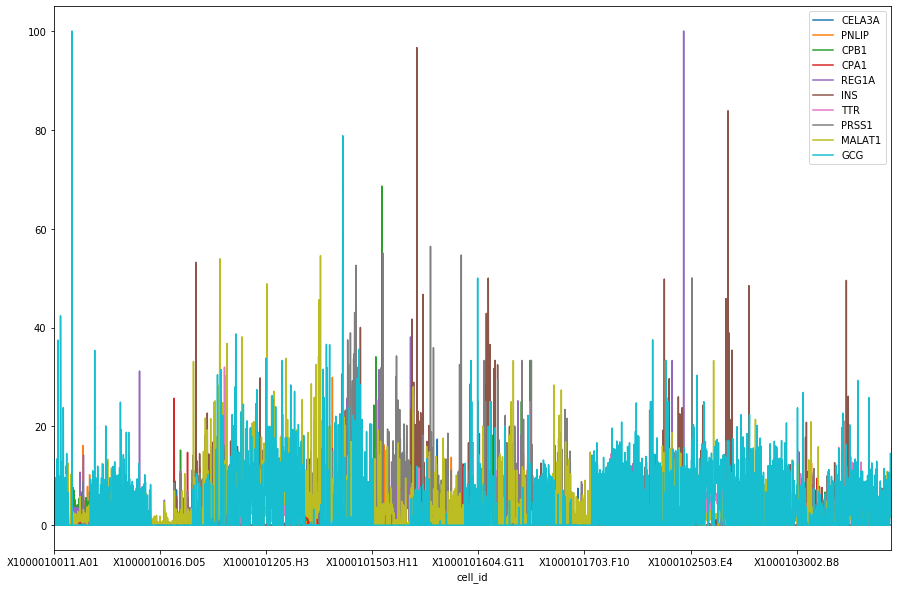

In [0]:
expression_df_top=expression_df[top_genes.index]
expression_df_top.plot(figsize=(15,10))

In [0]:
corr=expression_df_top.corr()
corr

,CELA3A,PNLIP,CPB1,CPA1,REG1A,INS,TTR,PRSS1,MALAT1,GCG
CELA3A,1.000000,0.477142,0.445427,0.591556,0.357168,-0.064903,-0.190741,0.588297,-0.053860,-0.184550
PNLIP,0.477142,1.000000,0.497087,0.534277,0.293723,-0.051933,-0.161087,0.460968,-0.092318,-0.157375
CPB1,0.445427,0.497087,1.000000,0.527556,0.310590,-0.056301,-0.166963,0.453533,-0.077581,-0.170213
CPA1,0.591556,0.534277,0.527556,1.000000,0.362447,-0.062035,-0.183610,0.606975,-0.065938,-0.196677
REG1A,0.357168,0.293723,0.310590,0.362447,1.000000,-0.060414,-0.150237,0.436170,-0.064233,-0.157877
INS,-0.064903,-0.051933,-0.056301,-0.062035,-0.060414,1.000000,-0.099305,-0.068985,-0.020077,-0.128514
TTR,-0.190741,-0.161087,-0.166963,-0.183610,-0.150237,-0.099305,1.000000,-0.172543,0.009534,0.561719
PRSS1,0.588297,0.460968,0.453533,0.606975,0.436170,-0.068985,-0.172543,1.000000,-0.084229,-0.196329
MALAT1,-0.053860,-0.092318,-0.077581,-0.065938,-0.064233,-0.020077,0.009534,-0.084229,1.000000,-0.022060
GCG,-0.184550,-0.157375,-0.170213,-0.196677,-0.157877,-0.128514,0.561719,-0.196329,-0.022060,1.000000


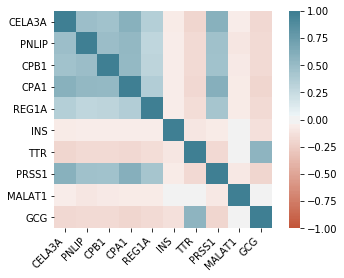

In [0]:
import seaborn as sns
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

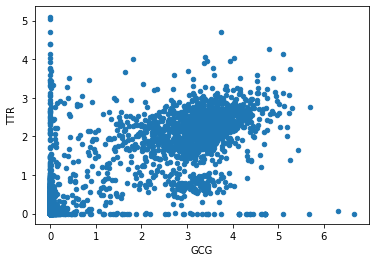

In [89]:
np.log2(expression_df_top+1).plot.scatter('GCG','TTR')

In [0]:
d=expression_df_top[['GCG','TTR']]
d=d[d.GCG*d.TTR>1]

In [0]:
x=np.log2(d+1)['GCG'].values
y=np.log2(d+1)['TTR'].values

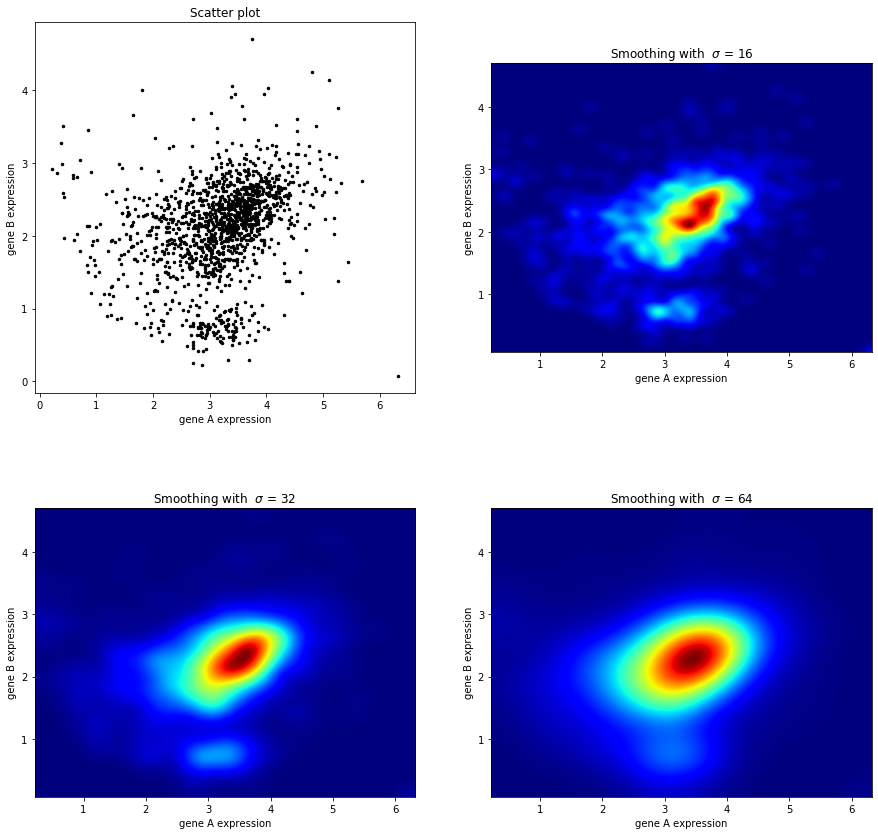

In [98]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.ndimage.filters import gaussian_filter


def myplot(x, y, s, bins=1000):
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
    heatmap = gaussian_filter(heatmap, sigma=s)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    return heatmap.T, extent


fig, axs = plt.subplots(2, 2,figsize=(15,15))


# Generate some test data

sigmas = [0, 16, 32, 64]

for ax, s in zip(axs.flatten(), sigmas):
    ax.set(xlabel='gene A expression', ylabel='gene B expression')
    if s == 0:
        ax.plot(x, y, 'k.', markersize=5)
        ax.set_title("Scatter plot")
    else:
        img, extent = myplot(x, y, s)
        ax.imshow(img, extent=extent, origin='lower', cmap=cm.jet)
        ax.set_title("Smoothing with  $\sigma$ = %d" % s)

plt.show()